In [ ]:
#================DEMO===========================

In [ ]:
# @lib:
import folium
from folium.plugins import DualMap
from branca.element import Template, MacroElement
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Iterable, List, Tuple
import datetime as dt
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely import wkt
from google.cloud import storage
from google.oauth2 import service_account
import time, gcsfs, os, math, random, time, pickle, json, gc, hashlib, logging, rasterio, torch
from rasterio.io import MemoryFile
import torchvision.transforms as transforms
from torch.utils.data import(DataLoader, random_split, Dataset, IterableDataset, WeightedRandomSampler, ConcatDataset,
    Subset,
)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report
from google.oauth2 import service_account
from google.cloud import storage
from typing import Optional, Dict, List, Tuple, Iterator, Union
from pathlib import Path
from functools import lru_cache
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
import torch.multiprocessing as mp
warnings.filterwarnings('ignore')



In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())


True
0
NVIDIA L40-16Q


In [ ]:
# Replace this with the correct path to JSON key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ee-XX.json"

# Connect to Google Cloud Storage
client = storage.Client()

# List files from the bucket
bucket_name = "crop_dl"
bucket = client.bucket(bucket_name)
blobs = bucket.list_blobs()

#print("Files in bucket:")
#for blob in blobs:
    #print(blob.name)


##Augmentation

In [ ]:
class RandomRotation:
    """
    Randomly rotates the sample (both image and spatial label components)
    by a multiple of 90°.
    """
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, sample):
        # Randomly choose an angle
        angle = random.choice(self.angles)
        k = angle // 90  

        # Rotate the image tensor.
        # image shape is (T, 4, H, W); we rotate the last two dims.
        sample['image'] = torch.rot90(sample['image'], k, dims=(2, 3))

        # Rotate spatial labels if present.
        if 'label' in sample:
            for key in ['Class_label', 'Sub_class_label', 'Name_label']:
                if key in sample['label']:
                    # Each label is expected to have shape (H, W)
                    sample['label'][key] = torch.rot90(sample['label'][key], k, dims=(0, 1))

        # The global labels and meta data (e.g., Year, month)
        return sample

class RandomHorizontalFlip:
    """
    Randomly flips the sample horizontally with a probability of 0.5
    """
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        if random.random() < self.p:
            # Flip images (T, 4, H, W)
            sample['image'] = torch.flip(sample['image'], dims=[3])

            # Flip labels
            if 'label' in sample:
                for key in ['Class_label', 'Sub_class_label', 'Name_label']:
                    if key in sample['label']:
                        sample['label'][key] = torch.flip(sample['label'][key], dims=[1])

        return sample

class RandomVerticalFlip:
    """
    Randomly flips the sample vertically with a probability of 0.5
    """
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        if random.random() < self.p:
            # Flip images (T, 4, H, W)
            sample['image'] = torch.flip(sample['image'], dims=[2])

            # Flip labels
            if 'label' in sample:
                for key in ['Class_label', 'Sub_class_label', 'Name_label']:
                    if key in sample['label']:
                        sample['label'][key] = torch.flip(sample['label'][key], dims=[0])

        return sample

class RandomNoise:
    """
    Adds random Gaussian noise to the image bands to simulate sensor variations
    """
    def __init__(self, mean=0.0, std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        noise = torch.randn_like(sample['image']) * self.std + self.mean
        sample['image'] = sample['image'] + noise
        return sample

class ComposeTransforms:
    """
    Composes multiple transforms together
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

#Re-indexed/mapped labels, Use ready made extracted idx to save compuonal extraction time

In [5]:
MAPS = {
    'class': {
        'idx': {'Crop': 0, 'Fallow': 1, 'Noncrop': 2},
        'string': {0: 'Crop', 1: 'Fallow', 2: 'Noncrop'}
    },
    'sub': {
        'idx': {
            'Bare_Built_Up': 0,
            'Cereals': 1,
            'Fallow': 2,
            'Legumes': 3,
            'Noncrop': 4,
            'Other_Vegetation': 5,
            'Tree_Crops': 6,
            'Vegetables': 7
        },
        'string': {
            0: 'Bare_Built_Up',
            1: 'Cereals',
            2: 'Fallow',
            3: 'Legumes',
            4: 'Noncrop',
            5: 'Other_Vegetation',
            6: 'Tree_Crops',
            7: 'Vegetables'
        },
        'children': {
            0: [1, 3, 6, 7],    # Crop: Cereals, Legumes, Tree_Crops, Vegetables
            1: [2],             # Fallow: Fallow
            2: [0, 4, 5],       # Noncrop: Bare_Built_Up, Noncrop, Other_Vegetation
        }
    },
    'name': {
        'idx': {
            'Bare_Soil': 0, 'Bean': 1, 'Bissap': 2, 'Bissap_Groundnut': 3, 'Built_Up': 4,
            'Cabbage': 5, 'Cashew': 6, 'Cassava': 7, 'Cemetery': 8, 'Citrus_Tree': 9,
            'Cotton': 10, 'Cotton_Other_Crops': 11, 'Cowpea': 12, 'Cowpea_Bissap': 13,
            'Cowpea_Mixed': 14, 'Cowpea_Pasture': 15, 'Cowpea_Soybean': 16, 'Eggplant': 17,
            'Fallow': 18, 'Fonio': 19, 'Fruit_Crop': 20, 'Groundnut': 21, 'Groundnut_Mixed': 22,
            'Guinea_Sorrel': 23, 'Laterite_Road': 24, 'Legumes': 25, 'Maize': 26,
            'Maize_Bissap': 27, 'Maize_Gum': 28, 'Maize_Millet': 29, 'Maize_Other': 30,
            'Maize_Sorghum': 31, 'Mango_Tree': 32, 'Millet': 33, 'Millet_Bissap': 34,
            'Millet_Cowpea': 35, 'Millet_Groundnut': 36, 'Millet_Maize': 37, 'Millet_Mixed': 38,
            'Millet_Pasture': 39, 'Noncrop': 40, 'Okra': 41, 'Okra_Maize': 42, 'Onion': 43,
            'Paved_Road': 44, 'Potato': 45, 'Quarry': 46, 'Rice': 47, 'Sandy_Road': 48,
            'School': 49, 'Sesame': 50, 'Sesame_Bissap': 51, 'Sesame_Millet': 52,
            'Sorghum': 53, 'Soybean': 54, 'Squash': 55, 'Sugarcane': 56, 'Sweet_Potato': 57,
            'Taro': 58, 'Tomato': 59, 'Track': 60, 'Vegetation': 61, 'Vouandzou': 62,
            'Watermelon': 63, 'Wheat': 64
        },
        'string': {
            0: 'Bare_Soil', 1: 'Bean', 2: 'Bissap', 3: 'Bissap_Groundnut', 4: 'Built_Up',
            5: 'Cabbage', 6: 'Cashew', 7: 'Cassava', 8: 'Cemetery', 9: 'Citrus_Tree',
            10: 'Cotton', 11: 'Cotton_Other_Crops', 12: 'Cowpea', 13: 'Cowpea_Bissap',
            14: 'Cowpea_Mixed', 15: 'Cowpea_Pasture', 16: 'Cowpea_Soybean', 17: 'Eggplant',
            18: 'Fallow', 19: 'Fonio', 20: 'Fruit_Crop', 21: 'Groundnut', 22: 'Groundnut_Mixed',
            23: 'Guinea_Sorrel', 24: 'Laterite_Road', 25: 'Legumes', 26: 'Maize',
            27: 'Maize_Bissap', 28: 'Maize_Gum', 29: 'Maize_Millet', 30: 'Maize_Other',
            31: 'Maize_Sorghum', 32: 'Mango_Tree', 33: 'Millet', 34: 'Millet_Bissap',
            35: 'Millet_Cowpea', 36: 'Millet_Groundnut', 37: 'Millet_Maize', 38: 'Millet_Mixed',
            39: 'Millet_Pasture', 40: 'Noncrop', 41: 'Okra', 42: 'Okra_Maize', 43: 'Onion',
            44: 'Paved_Road', 45: 'Potato', 46: 'Quarry', 47: 'Rice', 48: 'Sandy_Road',
            49: 'School', 50: 'Sesame', 51: 'Sesame_Bissap', 52: 'Sesame_Millet',
            53: 'Sorghum', 54: 'Soybean', 55: 'Squash', 56: 'Sugarcane', 57: 'Sweet_Potato',
            58: 'Taro', 59: 'Tomato', 60: 'Track', 61: 'Vegetation', 62: 'Vouandzou',
            63: 'Watermelon', 64: 'Wheat'
        },
        'children': {
    # (class_label, sub_class_label): [list of name_label integers]
    (2, 0): [0, 4, 8, 24, 44, 46, 48, 49, 60],       # Noncrop - Bare_Built_Up
    (0, 1): [19, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 47, 53, 56, 64], # Crop - Cereals
    (1, 2): [18],                                     # Fallow - Fallow
    (0, 3): [1, 12, 13, 14, 15, 16, 21, 22, 25, 36, 54, 62],  # Crop - Legumes
    (2, 4): [40],                                     # Noncrop - Noncrop
    (2, 5): [61],                                     # Noncrop - Other_Vegetation
    (0, 6): [6, 9, 10, 11, 20, 32],                   # Crop - Tree_Crops
    (0, 7): [2, 3, 5, 7, 17, 23, 41, 42, 43, 45, 50, 51, 52, 55, 57, 58, 59, 63], # Crop - Vegetables
        }  
    },

    'year': {
        'idx': {0: 0, 2020: 1, 2023: 2}
    },
    'month': {
        'idx': {8.0: 0, 9.0: 1, 10.0: 2}
    }
}


NUM_CLASSES = {k: len(v['idx']) for k, v in MAPS.items()}


# Month mapping helper
MONTH_MAP = {
    "Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6,
    "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12
}

In [ ]:
#Create a fast lookup for all (class, sub) → allowed name_labels:
import collections

#full NAME table as Python tuples:
NAME_TABLE = [
    ('Noncrop', 'Bare_Soil', 0, 'Bare_Built_Up'),
    ('Crop', 'Bean', 1, 'Legumes'),
    ('Crop', 'Bissap', 2, 'Vegetables'),
    ('Crop', 'Bissap_Groundnut', 3, 'Vegetables'),
    ('Noncrop', 'Built_Up', 4, 'Bare_Built_Up'),
    ('Crop', 'Cabbage', 5, 'Vegetables'),
    ('Crop', 'Cashew', 6, 'Tree_Crops'),
    ('Crop', 'Cassava', 7, 'Vegetables'),
    ('Noncrop', 'Cemetery', 8, 'Bare_Built_Up'),
    ('Crop', 'Citrus_Tree', 9, 'Tree_Crops'),
    ('Crop', 'Cotton', 10, 'Tree_Crops'),
    ('Crop', 'Cotton_Other_Crops', 11, 'Tree_Crops'),
    ('Crop', 'Cowpea', 12, 'Legumes'),
    ('Crop', 'Cowpea_Bissap', 13, 'Legumes'),
    ('Crop', 'Cowpea_Mixed', 14, 'Legumes'),
    ('Crop', 'Cowpea_Pasture', 15, 'Legumes'),
    ('Crop', 'Cowpea_Soybean', 16, 'Legumes'),
    ('Crop', 'Eggplant', 17, 'Vegetables'),
    ('Fallow', 'Fallow', 18, 'Fallow'),
    ('Crop', 'Fonio', 19, 'Cereals'),
    ('Crop', 'Fruit_Crop', 20, 'Tree_Crops'),
    ('Crop', 'Groundnut', 21, 'Legumes'),
    ('Crop', 'Groundnut_Mixed', 22, 'Legumes'),
    ('Crop', 'Guinea_Sorrel', 23, 'Vegetables'),
    ('Noncrop', 'Laterite_Road', 24, 'Bare_Built_Up'),
    ('Crop', 'Legumes', 25, 'Legumes'),
    ('Crop', 'Maize', 26, 'Cereals'),
    ('Crop', 'Maize_Bissap', 27, 'Cereals'),
    ('Crop', 'Maize_Gum', 28, 'Cereals'),
    ('Crop', 'Maize_Millet', 29, 'Cereals'),
    ('Crop', 'Maize_Other', 30, 'Cereals'),
    ('Crop', 'Maize_Sorghum', 31, 'Cereals'),
    ('Crop', 'Mango_Tree', 32, 'Tree_Crops'),
    ('Crop', 'Millet', 33, 'Cereals'),
    ('Crop', 'Millet_Bissap', 34, 'Cereals'),
    ('Crop', 'Millet_Cowpea', 35, 'Cereals'),
    ('Crop', 'Millet_Groundnut', 36, 'Legumes'),
    ('Crop', 'Millet_Maize', 37, 'Cereals'),
    ('Crop', 'Millet_Mixed', 38, 'Cereals'),
    ('Crop', 'Millet_Pasture', 39, 'Cereals'),
    ('Noncrop', 'Noncrop', 40, 'Noncrop'),
    ('Crop', 'Okra', 41, 'Vegetables'),
    ('Crop', 'Okra_Maize', 42, 'Vegetables'),
    ('Crop', 'Onion', 43, 'Vegetables'),
    ('Noncrop', 'Paved_Road', 44, 'Bare_Built_Up'),
    ('Crop', 'Potato', 45, 'Vegetables'),
    ('Noncrop', 'Quarry', 46, 'Bare_Built_Up'),
    ('Crop', 'Rice', 47, 'Cereals'),
    ('Noncrop', 'Sandy_Road', 48, 'Bare_Built_Up'),
    ('Noncrop', 'School', 49, 'Bare_Built_Up'),
    ('Crop', 'Sesame', 50, 'Vegetables'),
    ('Crop', 'Sesame_Bissap', 51, 'Vegetables'),
    ('Crop', 'Sesame_Millet', 52, 'Vegetables'),
    ('Crop', 'Sorghum', 53, 'Cereals'),
    ('Crop', 'Soybean', 54, 'Legumes'),
    ('Crop', 'Squash', 55, 'Vegetables'),
    ('Crop', 'Sugarcane', 56, 'Cereals'),
    ('Crop', 'Sweet_Potato', 57, 'Vegetables'),
    ('Crop', 'Taro', 58, 'Vegetables'),
    ('Crop', 'Tomato', 59, 'Vegetables'),
    ('Noncrop', 'Track', 60, 'Bare_Built_Up'),
    ('Noncrop', 'Vegetation', 61, 'Other_Vegetation'),
    ('Crop', 'Vouandzou', 62, 'Legumes'),
    ('Crop', 'Watermelon', 63, 'Vegetables'),
    ('Crop', 'Wheat', 64, 'Cereals')
]

name_children = collections.defaultdict(set)
for class_str, name_str, name_label, sub_str in NAME_TABLE:
    class_label = MAPS['class']['idx'][class_str]
    sub_label = MAPS['sub']['idx'][sub_str]
    name_children[(class_label, sub_label)].add(name_label)

MAPS['name']['children'] = {k: sorted(list(v)) for k, v in name_children.items()}


#Model


In [ ]:

# Set up multiprocessing context
ctx = mp.get_context("spawn") 
ctx = torch.multiprocessing.get_context('spawn')
# imported from dataset.py script
from dataset import NumpyDataset 


In [ ]:

# ====== Model Architecture ======

class ConvLSTMCell(nn.Module):
    """A single ConvLSTM cell capturing spatial and temporal info."""
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding, bias=bias)
        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_out, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

class ConvLSTM(nn.Module):
    """Multi-layer ConvLSTM for sequence of images."""
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True):
        super().__init__()
        self.num_layers = num_layers
        self.cell_list = nn.ModuleList([
            ConvLSTMCell(
                input_dim=input_dim if i == 0 else hidden_dim,
                hidden_dim=hidden_dim,
                kernel_size=kernel_size,
                bias=bias,
            ) for i in range(num_layers)
        ])

    def forward(self, input):
        # input: [B, T, C, H, W]
        B, T, C, H, W = input.size()
        h = [torch.zeros(B, cell.hidden_dim, H, W, device=input.device) for cell in self.cell_list]
        c = [torch.zeros(B, cell.hidden_dim, H, W, device=input.device) for cell in self.cell_list]

        for t in range(T):
            x = input[:, t, :, :, :]
            for i, cell in enumerate(self.cell_list):
                h[i], c[i] = cell(x, h[i], c[i])
                x = h[i]
        return h[-1]   # Last hidden state of last layer

# ----- Class Model (Parent) -----
class ClassModel(nn.Module):
    def __init__(self, in_ch=4, hid=32, num_classes=3, kernel_size=3, lstm_layers=1):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=in_ch, hidden_dim=hid, kernel_size=kernel_size, num_layers=lstm_layers)
        self.classifier = nn.Sequential(
            nn.Conv2d(hid, hid, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hid, hid, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hid, num_classes, 1)
        )

    def forward(self, x):
        # x: [B, T, C, H, W]
        h = self.convlstm(x)  
        x = self.classifier(h)  
        x = F.adaptive_avg_pool2d(x, 1)  
        return x.view(x.size(0), -1)  

# ----- Sub-Class Model -----
class SubClassModel(nn.Module):
    def __init__(self, in_ch=4, hid=32, num_subs=3, kernel_size=3, lstm_layers=1):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=in_ch, hidden_dim=hid, kernel_size=kernel_size, num_layers=lstm_layers)
        self.classifier = nn.Sequential(
            nn.Conv2d(hid, hid, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hid, hid, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hid, num_subs, 1)
        )

    def forward(self, x):
        h = self.convlstm(x)
        x = self.classifier(h)
        x = F.adaptive_avg_pool2d(x, 1)
        return x.view(x.size(0), -1)

# ----- Name Model -----
class NameModel(nn.Module):
    def __init__(self, in_ch=4, hid=32, num_names=2, kernel_size=3, lstm_layers=1):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=in_ch, hidden_dim=hid, kernel_size=kernel_size, num_layers=lstm_layers)
        self.classifier = nn.Sequential(
            nn.Conv2d(hid, hid, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hid, hid, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hid, num_names, 1)
        )

    def forward(self, x):
        h = self.convlstm(x)
        x = self.classifier(h)
        x = F.adaptive_avg_pool2d(x, 1)
        return x.view(x.size(0), -1)


In [ ]:
# ========== LOAD DATA ===========

dataset_2023 = NumpyDataset('gs://crop_dl/XX/**', time_steps=3, strategy="full", max_windows=50)
dataset_2020 = NumpyDataset('gs://crop_dl/XX/**', time_steps=3, strategy="full", max_windows=50)
dataset = ConcatDataset([dataset_2023, dataset_2020])
total = len(dataset)
train_n = int(0.7 * total)
val_n   = int(0.15 * total)
test_n  = total - train_n - val_n
train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n])

In [ ]:

# ========== UTILS ==========
def get_indices_by_label(dataset, label_key, value):
    """Get indices in dataset where label_key == value."""
    indices = []
    for i in range(len(dataset)):
        sample = dataset[i]
        label = sample['label'][label_key]
        if label.ndim > 0:
            label = label.flatten()[0]
        else:
            label = label.item()
        if label == value:
            indices.append(i)
    return indices

def train_model(model, loader, label_key, device, epochs=2, relabel_fn=None):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    losses = []
    accs = []

    for ep in range(epochs):
        model.train()
        running_loss = 0
        total, correct = 0, 0
        for batch in loader:
            imgs = batch['image'].to(device)
            if relabel_fn:
                labels = relabel_fn(batch)
            else:
                labels = batch['label'][label_key].to(device)
                labels = labels.view(labels.size(0), -1)[:, 0]
            logits = model(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        avg_loss = running_loss / len(loader)
        avg_acc = 100 * correct / total
        losses.append(avg_loss)
        accs.append(avg_acc)
        print(f"Epoch {ep+1}: loss={avg_loss:.4f}, acc={avg_acc:.2f}%")
    return model, losses, accs
 

def eval_model(model, loader, label_key, device, class_names):
    """Evaluate model and print metrics."""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch in loader:
            imgs = batch['image'].to(device)
            labels = batch['label'][label_key].to(device)
            labels = labels.view(labels.size(0), -1)[:, 0]
            logits = model(imgs)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(labels.cpu().numpy())
    print("\n--- Classification Report ---")
    print(classification_report(all_targets, all_preds, target_names=class_names, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(all_targets, all_preds))
    print("Overall Accuracy: {:.4f}".format(accuracy_score(all_targets, all_preds)))

Found 40877 .npy files
Created 740 samples using full strategy
Found 36756 .npy files
Created 1123 samples using full strategy

[Stage 1] Train CLASS model
Epoch 1: loss=0.9550, acc=44.56%
Epoch 2: loss=0.5631, acc=86.20%
[Stage 1] Validation:

--- Classification Report ---
              precision    recall  f1-score   support

        Crop       0.87      1.00      0.93       244
      Fallow       0.00      0.00      0.00        10
     Noncrop       0.00      0.00      0.00        25

    accuracy                           0.87       279
   macro avg       0.29      0.33      0.31       279
weighted avg       0.76      0.87      0.82       279

Confusion Matrix:
 [[244   0   0]
 [ 10   0   0]
 [ 25   0   0]]
Overall Accuracy: 0.8746
Saved ClassModel to models/class_model.pth


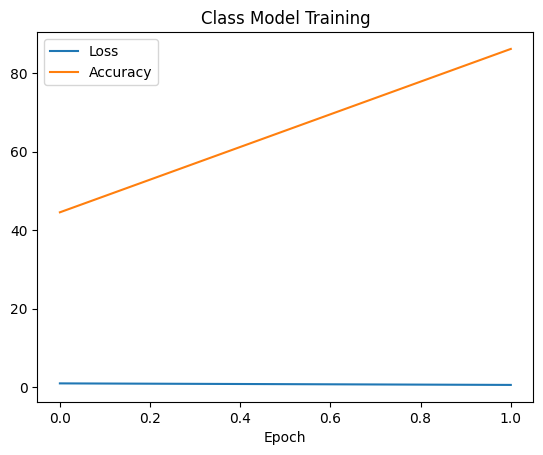

  [Stage 2, class=0] Epoch 1: loss=1.0820, acc=39.82%
  [Stage 2, class=0] Epoch 2: loss=1.0420, acc=46.94%
  [Stage 2, class=0] Validation:
              precision    recall  f1-score   support

     Cereals       0.45      1.00      0.62       104
     Legumes       0.00      0.00      0.00        92
  Tree_Crops       0.00      0.00      0.00        34

    accuracy                           0.45       230
   macro avg       0.15      0.33      0.21       230
weighted avg       0.20      0.45      0.28       230

Saved SubClassModel for class=0.
Epoch 1: loss=1.0339, acc=46.94%
Epoch 2: loss=1.0205, acc=46.94%


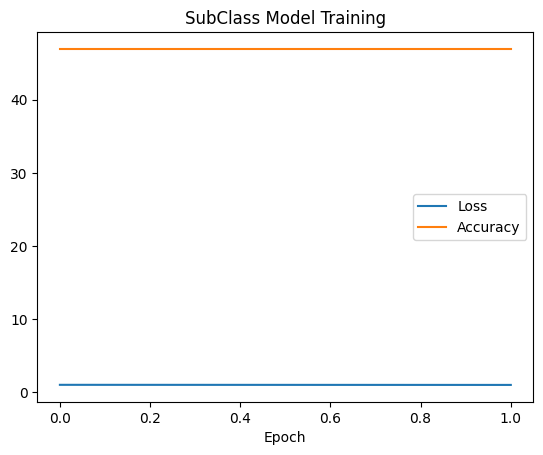

    [Stage 3, class=0, sub=1] Epoch 1: loss=1.9153, acc=14.03%
    [Stage 3, class=0, sub=1] Epoch 2: loss=1.8959, acc=14.03%
    [Stage 3, class=0, sub=1] Validation:
                precision    recall  f1-score   support

         Fonio       0.00      0.00      0.00         2
         Maize       0.00      0.00      0.00        11
     Maize_Gum       0.00      0.00      0.00         4
  Maize_Millet       0.00      0.00      0.00         5
   Maize_Other       0.00      0.00      0.00         0
 Millet_Cowpea       0.00      0.00      0.00        14
Millet_Pasture       0.28      1.00      0.44        14

     micro avg       0.28      0.28      0.28        50
     macro avg       0.04      0.14      0.06        50
  weighted avg       0.08      0.28      0.12        50

Saved NameModel for class=0, sub=1.
    [Stage 3, class=0, sub=3] Epoch 1: loss=1.0676, acc=48.75%
    [Stage 3, class=0, sub=3] Epoch 2: loss=1.0611, acc=48.75%
    [Stage 3, class=0, sub=3] Validation:
         

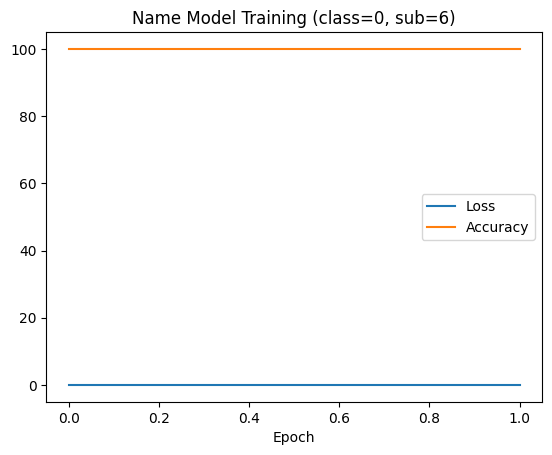

Strict hierarchical training complete.


In [ ]:



# ========== HIERARCHICAL TRAINING ==========
def flatten_label(label): 
    return label.flatten()[0] if label.ndim > 0 else label.item()
    
def strict_hierarchy_pipeline(train_ds, val_ds, device="cpu"):
    # === Stage 1: Train Class model ===
    print("\n[Stage 1] Train CLASS model")
    class_label = sorted(MAPS['class']['idx'].values())
    class_string = [MAPS['class']['string'][i] for i in class_label]
    class_model = ClassModel(num_classes=len(class_label)).to(device)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, multiprocessing_context=ctx, pin_memory=True, num_workers=8)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, multiprocessing_context=ctx, pin_memory=True, num_workers=8)
    class_model, class_losses, class_accs = train_model(class_model, train_loader, 'class_label', device, epochs=2)
    print("[Stage 1] Validation:")
    eval_model(class_model, val_loader, 'class_label', device, class_string)
    
    #save model
    torch.save(class_model.state_dict(), "models/class_model.pth")
    print("Saved ClassModel to models/class_model.pth")

    #plot
    plt.figure()
    plt.plot(class_losses, label='Loss')
    plt.plot(class_accs, label='Accuracy')
    plt.title('Class Model Training')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


    # === Stage 2: Sub-Class Model (Crop only) ===
    sub_models = {}
    CROP_CODE = MAPS['class']['idx']['Crop']
    CROP_SUB_LABELS = MAPS['sub']['children'][CROP_CODE]

    crop_indices_train = [
        i for i in get_indices_by_label(train_ds, 'class_label', CROP_CODE)
        #if train_ds[i]['label']['sub_label'].item() in CROP_SUB_LABELS
        if flatten_label(train_ds[i]['label']['sub_label']) in CROP_SUB_LABELS
    ]
    crop_indices_val = [
        i for i in get_indices_by_label(val_ds, 'class_label', CROP_CODE)
        if flatten_label(val_ds[i]['label']['sub_label']) in CROP_SUB_LABELS
    ]
    train_subset = Subset(train_ds, crop_indices_train)
    val_subset = Subset(val_ds, crop_indices_val)
    #train_sub_labels = [train_subset[i]['label']['sub_label'].item() for i in range(len(train_subset))]
    train_sub_labels = [int(flatten_label(train_subset[i]['label']['sub_label'])) for i in range(len(train_subset))]
    sub_classes = sorted(set(train_sub_labels))
    sub_label_to_idx = {int(sub): idx for idx, sub in enumerate(sub_classes)}
    sub_string = [MAPS['sub']['string'][sub] for sub in sub_classes]
    sub_model = SubClassModel(num_subs=len(sub_classes)).to(device)
    optimizer = torch.optim.Adam(sub_model.parameters(), lr=1e-3)
    def relabel(batch):
        labels = batch['label']['sub_label'].view(batch['label']['sub_label'].size(0), -1)[:, 0]
        return torch.tensor([sub_label_to_idx[int(l.item())] for l in labels], device=device)

        
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, multiprocessing_context=ctx, pin_memory=True, num_workers=8)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, multiprocessing_context=ctx, pin_memory=True, num_workers=8)
    for ep in range(2):
        sub_model.train()
        running_loss = 0
        total, correct = 0, 0
        for batch in train_loader:
            imgs = batch['image'].to(device)
            labels = relabel(batch)
            logits = sub_model(imgs)
            loss = nn.CrossEntropyLoss()(logits, labels)
            nn.utils.clip_grad_norm_(sub_model.parameters(), 1.0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"  [Stage 2, class={CROP_CODE}] Epoch {ep+1}: loss={running_loss/len(train_loader):.4f}, acc={100*correct/total:.2f}%")
    print(f"  [Stage 2, class={CROP_CODE}] Validation:")
    all_preds, all_targets = [], []
    sub_model.eval()
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch['image'].to(device)
            labels = relabel(batch)
            logits = sub_model(imgs)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(labels.cpu().numpy())
    print(classification_report(all_targets, all_preds, target_names=sub_string, zero_division=0))
    sub_models[CROP_CODE] = (sub_model, sub_label_to_idx, sub_string)
    #save model
    torch.save(sub_model.state_dict(), f"models/sub_model_class{CROP_CODE}.pth")
    print(f"Saved SubClassModel for class={CROP_CODE}.")
    
    #Plot
    sub_model, sub_losses, sub_accs = train_model(sub_model, train_loader, None, device, epochs=2, relabel_fn=relabel)
    plt.figure()
    plt.plot(sub_losses, label='Loss')
    plt.plot(sub_accs, label='Accuracy')
    plt.title('SubClass Model Training')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # === Stage 3: Name Model (per Crop sub-class) ===
    name_models = {}
    for sub in sub_classes:
        name_labels_allowed = MAPS['name']['children'][(CROP_CODE, sub)]
        sub_indices_train = [
            i for i in crop_indices_train
            if flatten_label(train_ds[i]['label']['sub_label']) == sub
            and flatten_label(train_ds[i]['label']['name_label']) in name_labels_allowed
        ]
        sub_indices_val = [
            i for i in crop_indices_val
            if flatten_label(val_ds[i]['label']['sub_label']) == sub
            and flatten_label(val_ds[i]['label']['name_label']) in name_labels_allowed
        ]        
        train_subset = Subset(train_ds, sub_indices_train)
        val_subset = Subset(val_ds, sub_indices_val)
        train_name_labels = [int(flatten_label(train_subset[i]['label']['name_label'])) for i in range(len(train_subset))]
        names = sorted(set(train_name_labels))
        
        name_model = NameModel(num_names=len(names)).to(device)
        optimizer = torch.optim.Adam(name_model.parameters(), lr=1e-3)
        name_label_to_idx = {int(n): idx for idx, n in enumerate(names)}
        name_string = [MAPS['name']['string'][n] for n in names]
        def relabel_name(batch):
            labels = batch['label']['name_label'].view(batch['label']['name_label'].size(0), -1)[:, 0]
            return torch.tensor([name_label_to_idx[int(l.item())] for l in labels], device=device)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, multiprocessing_context=ctx, pin_memory=True, num_workers=8)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, multiprocessing_context=ctx, pin_memory=True, num_workers=8)
        for ep in range(2):
            name_model.train()
            running_loss = 0
            total, correct = 0, 0
            for batch in train_loader:
                imgs = batch['image'].to(device)
                labels = relabel_name(batch)
                logits = name_model(imgs)
                loss = nn.CrossEntropyLoss()(logits, labels)
                nn.utils.clip_grad_norm_(name_model.parameters(), 1.0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                preds = logits.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            print(f"    [Stage 3, class={CROP_CODE}, sub={sub}] Epoch {ep+1}: loss={running_loss/len(train_loader):.4f}, acc={100*correct/total:.2f}%")
        print(f"    [Stage 3, class={CROP_CODE}, sub={sub}] Validation:")
        all_preds, all_targets = [], []
        name_model.eval()
        with torch.no_grad():
            for batch in val_loader:
                imgs = batch['image'].to(device)
                labels = relabel_name(batch)
                logits = name_model(imgs)
                preds = logits.argmax(1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(labels.cpu().numpy())
        print(classification_report(all_targets,
                                    all_preds,labels=list(range(len(name_string))),
                                    target_names=name_string,
                                                zero_division=0))

        name_models[(CROP_CODE, sub)] = (name_model, name_label_to_idx, name_string)
        
        #same Model
        torch.save(name_model.state_dict(),
                   f"models/name_model_class{CROP_CODE}_sub{sub}.pth")
        print(f"Saved NameModel for class={CROP_CODE}, sub={sub}.")
        #Plot
    name_model, name_losses, name_accs = train_model(name_model, train_loader, None, device, epochs=2, relabel_fn=relabel_name)
    plt.figure()
    plt.plot(name_losses, label='Loss')
    plt.plot(name_accs, label='Accuracy')
    plt.title(f'Name Model Training (class={CROP_CODE}, sub={sub})')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


    print("Strict hierarchical training complete.")
    return class_model, sub_models, name_models

# ========== MAIN ==========

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    strict_hierarchy_pipeline(train_ds, val_ds, device=device)

if __name__ == "__main__":
    main()
